In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time;  from datetime import datetime
import math
plt.rcParams["figure.figsize"] = (15,10)

In [2]:
# this will have to come from overall function call. It is the difference in local time from PST.
offset_from_pst = 3
cost_mobile_user = .28
cost_desklet_user = .45

In [8]:
nyc = pd.read_csv('gapi_city_data-export-2017-11-30.csv') # read the gapi database
nyc.dropna(axis=1, how='all', inplace=True) # drops all columns where all values are NaN
nyc.drop("Organic Searches", axis=1,inplace=True) # Drops Organic Searches column
nyc = nyc.loc[nyc['City'] == 1023191] # Selects records only NYC

In [9]:
nyc["Date Hour"].max(),nyc["Date Hour"].min()

(2017111723, 2014042008)

In [10]:
weather = pd.read_csv('open_weather_6cities.csv')  # read the weather database
weather.dropna(axis=1, how='all', inplace=True) # drops all columns where all values are NaN
weather = weather.loc[weather['city_id'] == 5128581] # Selects records only NYC

In [11]:
weather.weather_id.unique()

array([800, 801, 803, 804, 500, 501, 802, 502, 701, 721, 741, 600, 616,
       615, 601, 602, 503, 300, 301, 201, 211, 200, 202, 771, 711, 302,
       511, 230, 751, 521, 231, 520, 761, 731, 212])

In [15]:
df

,City,Date Hour,User Type,Device Category,Sessions,Bounces,Users,Transactions,Transaction Revenue,Revenue Per User,...,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon,concatenated
5882,1023191,2017070200,New Visitor,mobile,3,0,3,0,0.00,0.000000,...,NaN,NaN,NaN,NaN,90.0,701.0,Mist,mist,50n,51285811498978800
5883,1023191,2017070200,New Visitor,tablet,1,1,1,0,0.00,0.000000,...,NaN,NaN,NaN,NaN,90.0,701.0,Mist,mist,50n,51285811498978800
5884,1023191,2017070200,Returning Visitor,mobile,1,0,1,0,0.00,0.000000,...,NaN,NaN,NaN,NaN,90.0,701.0,Mist,mist,50n,51285811498978800
5885,1023191,2017070201,New Visitor,mobile,5,3,6,0,0.00,0.000000,...,NaN,NaN,NaN,NaN,90.0,701.0,Mist,mist,50n,51285811498982400
5886,1023191,2017070201,Returning Visitor,desktop,1,0,1,0,0.00,0.000000,...,NaN,NaN,NaN,NaN,90.0,701.0,Mist,mist,50n,51285811498982400
5887,1023191,2017070202,New Visitor,mobile,4,2,4,0,0.00,0.000000,...,NaN,NaN,NaN,NaN,90.0,701.0,Mist,mist,50n,51285811498986000
5887,1023191,2017070202,New Visitor,mobile,4,2,4,0,0.00,0.000000,...,NaN,NaN,NaN,NaN,90.0,741.0,Fog,fog,50n,51285811498986000
5888,1023191,2017070202,Returning Visitor,mobile,1,0,1,0,0.00,0.000000,...,NaN,NaN,NaN,NaN,90.0,701.0,Mist,mist,50n,51285811498986000
5888,1023191,2017070202,Returning Visitor,mobile,1,0,1,0,0.00,0.000000,...,NaN,NaN,NaN,NaN,90.0,741.0,Fog,fog,50n,51285811498986000
5903,1023191,2017070207,New Visitor,desktop,2,1,2,0,0.00,0.000000,...,NaN,NaN,NaN,NaN,0.0,800.0,Clear,Sky is Clear,01d,51285811499004000


In [12]:
## check non unique weather rows 
weather_nonunique= weather
a = weather_nonunique['city_id'].astype(str)
b = weather_nonunique['dt'].astype(str)
weather_nonunique['concatenated'] = a+b
# weather_nonunique['concatenated'].value_counts()

In [13]:
##Join tables on Unix Time and return df


# takes a string  in YYYMMDDHH (nyc(Date Hour)) and returns a Unix Time assuming local time zone for input
# this works because (local time on my machine) == (timezone of ga: time{set by ga account preferences}) 
def unixtimestamp(row):
    return int(int(time.mktime(datetime.strptime(row, "%Y%m%d%H").timetuple())))

# creates new column unix_time in nyc using unixtimestamp
nyc['unix_time'] = nyc.apply(lambda row: unixtimestamp(str(row['Date Hour'])), axis=1)

# join nyc to weather on unix_time 
df = nyc.join(weather.set_index('dt'), on='unix_time') 

In [14]:
#TODO: remove the need for this fix by importing fresh city data.

# fix to drop rows where no weather data
df = df.dropna(subset=['temp'])

In [9]:
## Remove nighttime records

## Should we retain nighttime records in a separate df to see changes there?

# night starts at 1 a.m,ends at 7 a.m. These hard coded values come from client.
night_start = 1
night_end = 6

# Adds hour column with only last two digits from Date Hour
df['Hour'] = df['Date Hour'].transform(str).str.slice(start=8).transform(int)

# function that given target city timezone offset from pst,
#returns start and end hours for the night in terms of pst
def offset_night_times(night_time,pst_offest):
    # if start/end time in pst is premidnight
    if night_time - pst_offest < 0:
        offset_night_time = 24 + night_time - pst_offest
    else:
        offset_night_time = night_time - pst_offest
    return (offset_night_time)

# calls above function and saves start and end of night in local time.
offset_night_start = offset_night_times(night_start,offset_from_pst)
offset_night_end = offset_night_times(night_end,offset_from_pst)

# drops night time values from df. if statement to accommdate possibility that target city night
# start is premidnight local time
def remove_night_hours_df():
    if offset_night_start>offset_night_end:
        df.drop(df[(df.Hour >= 22) | (df.Hour<= 3)].index, inplace=True)
    else:
        df.drop(df[(df.Hour >= 1) & (df.Hour<= 6)].index, inplace=True)

remove_night_hours_df()

# check that 18 unique values are left
assert df['Hour'].nunique() == 18

In [10]:
# Combine desktop and tablet into desklet in Device Category
df.loc[:,('Device Category')] = df.loc[:,('Device Category')].replace(to_replace=['desktop','tablet'],value='desklet')

In [11]:
## Split by weekday and weekend

def extract_month_from_unix(row):
     return int(datetime.fromtimestamp(row).strftime('%m'))
    
df['Month'] = df['unix_time'].apply(extract_month_from_unix)
    
def extract_day_from_unix(row):
    day = (datetime.fromtimestamp(row).strftime('%A'))
    if day == "Saturday" or day == "Sunday":
        return "Weekend"
    else:
        return "Weekday"

df['weekdayend'] = df['unix_time'].apply(extract_day_from_unix)

In [12]:
## Split by high/low season

high_season = [10,11,12,1,2]
def highlow_season(row):
    if row in high_season:
        return "High Season"
    else:
        return "Low Season"

df['Season'] = df['Month'].apply(highlow_season)

In [13]:
#split days into hot and cold
def hotcold(row):
    hot = 298  # ~25 C
    cold = 279 # ~5 C
    if row >= hot:
        return "Hot"
    elif row < cold:
        return "Cold"
    else:
        return "Regular"

df['hotcold'] = df['temp'].apply(hotcold)

# df.hotcold.value_counts()

In [14]:
## Map weather_id to main weather categories

def return_first_digit(row):
    return (str(row)[0])

df['weather_category'] = df.loc[:,('weather_id')].apply(return_first_digit)

weather_id_dict = {'2':'2 Thunderstorms','3':'3 Drizzle','5':'5 Rain','6':'6 Snow','7':'7 Atmosphere',
                   '8':'8 Clear','9':'9 Extreme'}

df = df.replace({'weather_category':weather_id_dict}) 

In [15]:
# return average for all values across a df that aren't nans
def average_df(df):
    values = []
    for x in df:
        for y in df[x]:
            if not math.isnan(y):
                values.append(y)
#     print (values)
    return sum(values) / float(len(values))

In [16]:
# Select columns 
df2= df[["User Type",'Device Category', 'hotcold', 'weekdayend', 'Season','Revenue Per User','weather_category']]

In [17]:
## Is the np.average function correct? Really think about it, and wether we can get something
## to optimise this.

#### So I have the data in the form that I want

What I need to do now is to present in a way that allows one to draw meaningful inferences.

So what am I trying to show?

I am trying to see how the intersectionality of weather zone with time of year, day, device, play into the average amount of money a user spends.

The problem with throwing this all into a chart is that the data gets really fragmented. Also the sparsity of data means that averages start to vary wildly.

Seprating dfs by column values is not helpful. For example, if we split into mobile and desklet, we lose any comparitive value because now they dont appear on the same graph.

Lets say there is a positive corelation with the weekends, for example. What kind of a graph would we have to see for that to be the case?

If we say that drizzle has a positive impact on both desklet and mobile. We could then say have the drizzle data split into weekends/weekdays etc and see if one is a lot higher than the others.

the same could be done for everyone else. so lets first work on figuring out the basic relationships, and then see if any of them can be improved using the weekend/day or hot/cold metrics.

So thats the conceptual, how do we implement it?





Something actionable to do - figure out the number and percentage of session that corresponds to each
of the bars in a chart.

Once I have this, I want to aggregate new and returning users - not a problem.

In [18]:
# number of sessions by weather category

percents = df2.pivot_table(
    index='weather_category',
    aggfunc='count'
)
def divide_by_total(row):
    return (row/df2.shape[0])*100

percents = percents.iloc[:,2].apply(divide_by_total)

percents

weather_category
2 Thunderstorms     1.481255
3 Drizzle           3.346413
5 Rain             17.141450
6 Snow              2.148839
7 Atmosphere       22.539877
8 Clear            53.342167
Name: Season, dtype: float64

In [19]:
# this is junk. totals have to come from df, not from averages of existing values.
# replace

def add_total_to_comparitive(input_dataframe,column):
    df = input_dataframe.copy()
    
    total_df = df2.pivot_table(
    index=column,
    columns='weather_category',values='Revenue Per User',
    aggfunc=np.average)
    
    df.reset_index(inplace=True)

    total_df.reset_index(inplace=True)
    print (total_df)

In [20]:
# this cell makes no sense if the previous one isnt accurate.
# examine and delete if it doesnt feed into anything later.

# both = df2.pivot_table(
#     index=['User Type','Device Category'], 
#     columns='weather_category',values='Revenue Per User', 
#     aggfunc=np.average)

# add_total_to_comparitive(both,"Season")

In [21]:
# Mobile Users - New and Returning

In [22]:
# Dash line - cost of acquiring mobile user

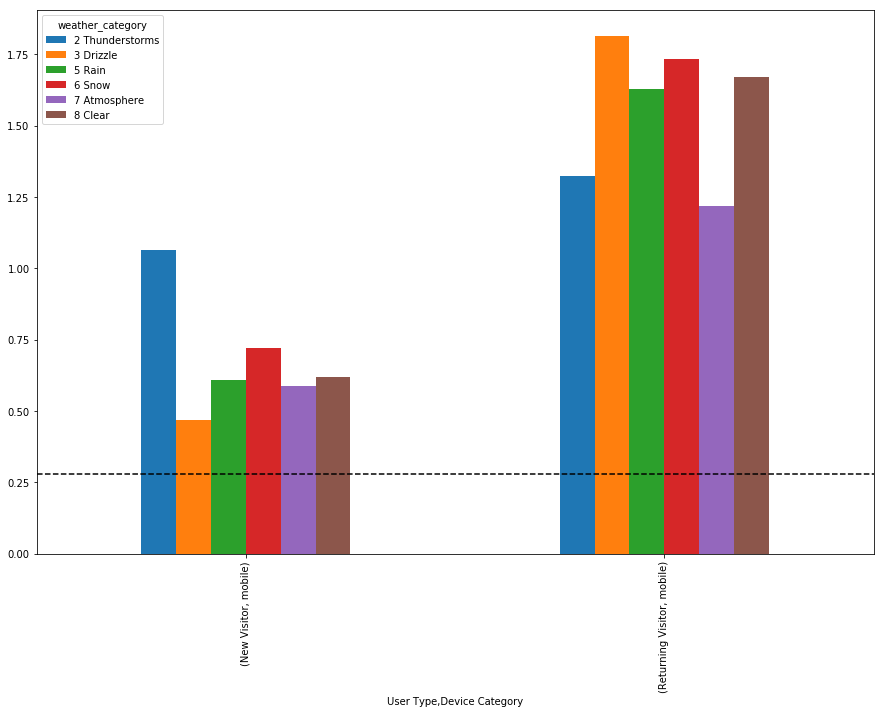

In [23]:
mobile = df2[df2['Device Category']=='mobile'].pivot_table(
    index=['User Type','Device Category'], 
    columns='weather_category',values='Revenue Per User', 
    aggfunc=np.average)


mobile.plot.bar().\
axhline(y=cost_mobile_user, color='black', linestyle='--')

There doesn't appear a robust correlation here, but what is visible is that the average revenue of returning visitors is significantly higher than the cost that Clay gave me. Could increasing that lead to overall increase in profit? By principle of making mc = mr, that would be the case.

In [24]:
# percentages of sesssions for mobile - new

new_visitor = df2[df2["User Type"] == "New Visitor"]
new_visitor_mobile = new_visitor[new_visitor["Device Category"] == 'mobile']

percents = new_visitor_mobile.pivot_table(
    index='weather_category',
    aggfunc='count')

def divide_by_total(row):
    return (row/df2.shape[0])*100

percents.iloc[:,2].apply(divide_by_total)



weather_category
2 Thunderstorms     0.404287
3 Drizzle           0.944470
5 Rain              4.995838
6 Snow              0.589444
7 Atmosphere        6.696224
8 Clear            15.648304
Name: Season, dtype: float64

In [25]:
# Desklet users - New and Returning

In [26]:
# Dash line - cost of acquiring desklet user

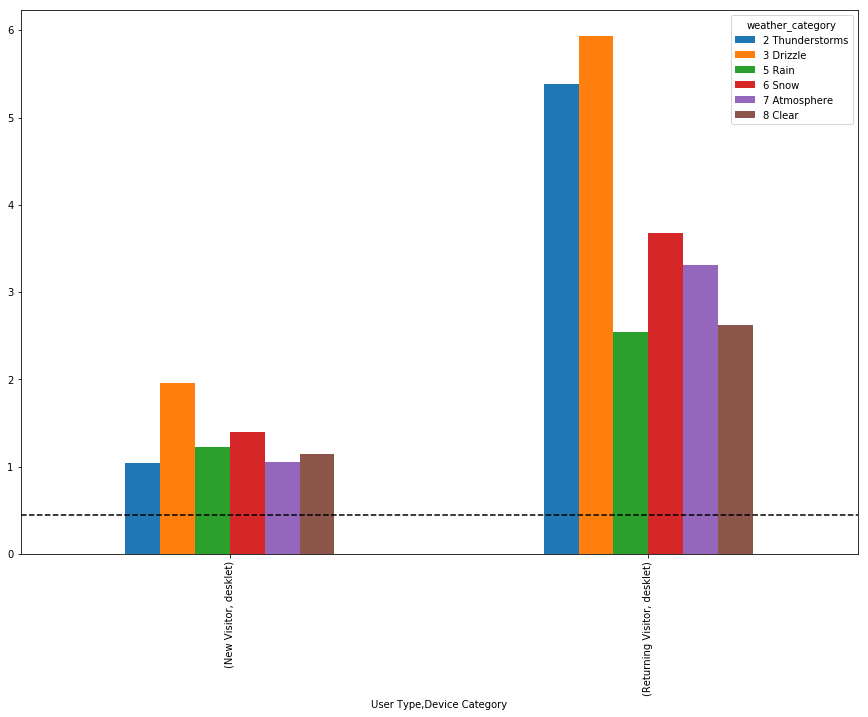

In [27]:
desklet = df2[df2['Device Category']=='desklet'].pivot_table(
    index=['User Type','Device Category'], 
    columns='weather_category',values='Revenue Per User', 
    aggfunc=np.average)

desklet.plot.bar().\
axhline(y=cost_desklet_user, color='black', linestyle='--')

In [28]:
# percentages of sesssions for desklet - new

new_visitor = df2[df2["User Type"] == "New Visitor"]
 
new_visitor_desklet = new_visitor[new_visitor["Device Category"] == 'desklet']


percents = new_visitor_desklet.pivot_table(
    index='weather_category',
    aggfunc='count'
)
def divide_by_total(row):
    return (row/df2.shape[0])*100

percents = percents.iloc[:,2].apply(divide_by_total)

percents



weather_category
2 Thunderstorms     0.521497
3 Drizzle           1.173793
5 Rain              6.137356
6 Snow              0.786492
7 Atmosphere        7.791877
8 Clear            19.008307
Name: Season, dtype: float64

There does seem to a positive correlation with drizzle acroos new and returning visitors. 
Snow is second highest in both, but by a smaller margin. Possible correlation.

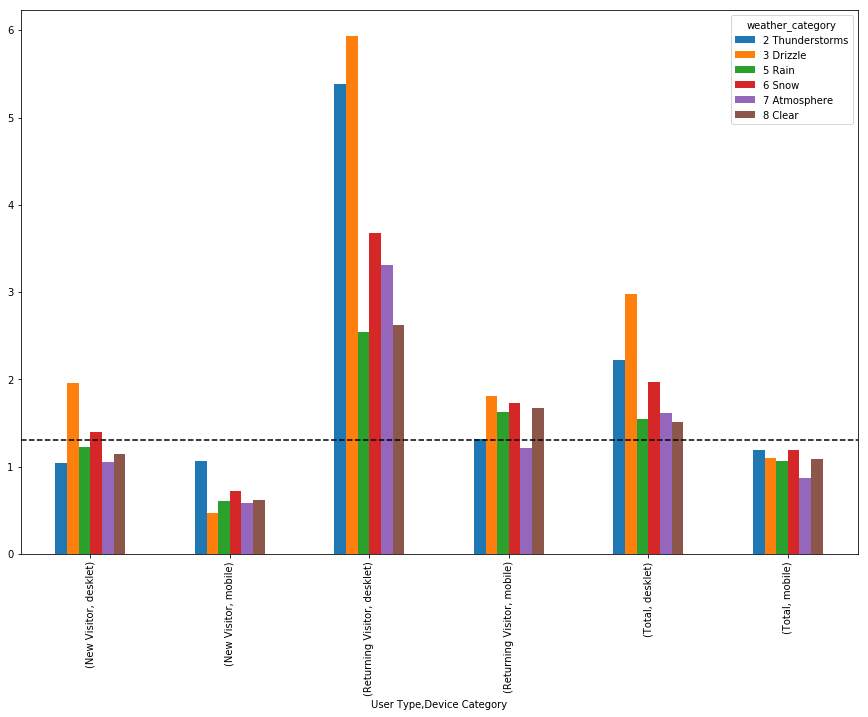

In [29]:
both = df2.pivot_table(
    index=['User Type','Device Category'], 
    columns='weather_category',values='Revenue Per User', 
    aggfunc=np.average)


total_device = df2.pivot_table(
    index=['Device Category'], 
    columns='weather_category',values='Revenue Per User', 
    aggfunc=np.average)


total_device = total_device.reset_index()
total_device.insert(0, 'User Type', "Total")

both_total = both.reset_index().append(total_device).set_index(['User Type','Device Category'])

overall_mean = df2.describe().iloc[1][0]


both_total.plot.bar().\
axhline(y=overall_mean, color='black', linestyle='--',label ='hello')


This graph shows average revenue split by user type and device. The horizontal line is the overall average revenue.

Clearly the segment with the highest average revenue is returning visitors on desklet. 

Thunderstorms, Drizzle and Snow account together account for about 7% of sessions. This doesn't mean that the elevated averages we're seeing for those categories aren't accurate, but we should be aware of it.


I want to add 2 more horizontal lines to reflect average cost for mobile and desklet. the best performing area is returning visitors,

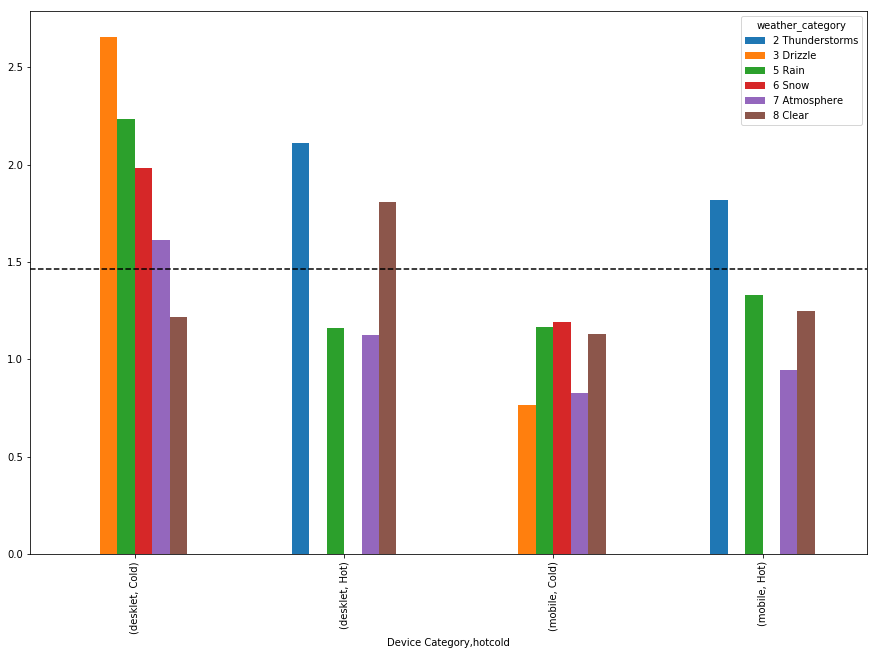

In [30]:
hot_cold_comparison = df2[df2.hotcold!='Regular'].pivot_table(
    index=['Device Category','hotcold'], 
    columns='weather_category',values='Revenue Per User', 
    aggfunc=np.average)


hot_cold_comparison_count = df2[df2.hotcold!='Regular'].pivot_table(
    index=['Device Category','hotcold'], 
    columns='weather_category',values='Revenue Per User', 
    aggfunc='count')


hot_cold_comparison_count_bool =hot_cold_comparison_count

# creates a df with boolean values with comparison condition 
for x in list(hot_cold_comparison_count):
    hot_cold_comparison_count_bool[x] = (hot_cold_comparison_count[x] >= 80)

filtered_hotcold = hot_cold_comparison_count_bool.dropna().multiply(hot_cold_comparison).replace(0, np.nan)
# hot_cold_comparison_count_bool#.multiply(hot_cold_comparison).replace(0, np.nan)

filtered_hotcold.plot.bar().\
axhline(y=average_df(filtered_hotcold), color='black', linestyle='--')


# Figure out the percentages of each above and below the mean
# Review methodology for calculating the mean 


# I will not add totals on this chart because lots of missing values, which would render such a view misleading.
# Even the lack of lines on this chart, caused by insufficient data will be less of a problem on other views


This graph has one interesting highlight, the first green bar. It indicated new users are far more likely to purchase on cold, thunderstorm days. This will feed back into seasonality (high season) because that is when these conditions will occur. 

Wondering now if seasonality is being captured by tempratures and weather in any case.

Also, we should change hot/cold cutoff to capture a portion of the values (1st and last quartile) instead of hard coding these values.

But should explore how cold, thunderstorms affect things.

Also, a box plot of this data showed a lot of insight. Shows the distrabution of values, rather than simply the mean.


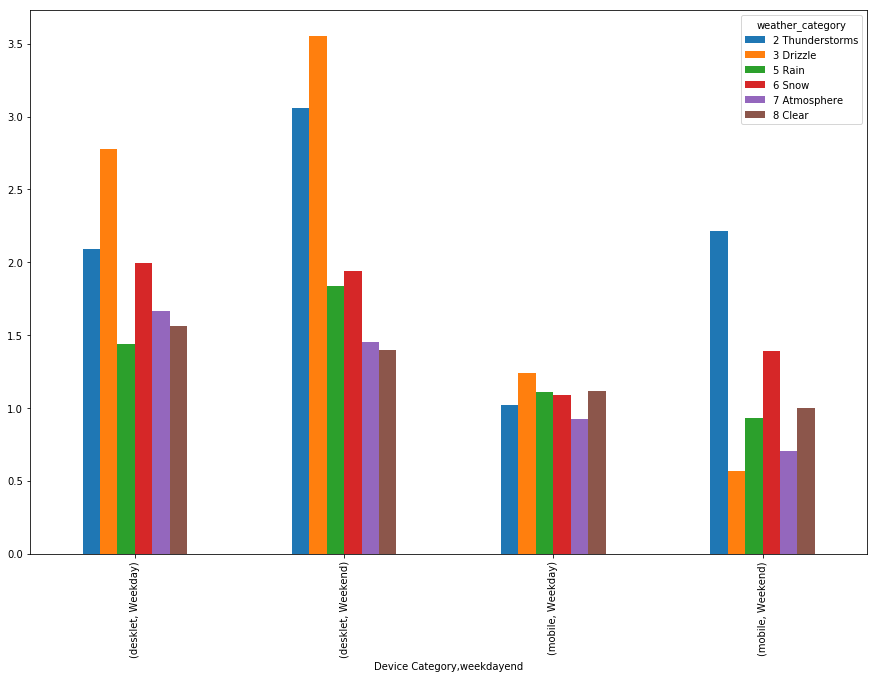

In [37]:
weekdayend_comparison_count = df2.pivot_table(
    index=['Device Category','weekdayend'], 
    columns='weather_category',values='Revenue Per User', 
    aggfunc=np.average).plot.bar()

In [31]:
# weekday vs weekend

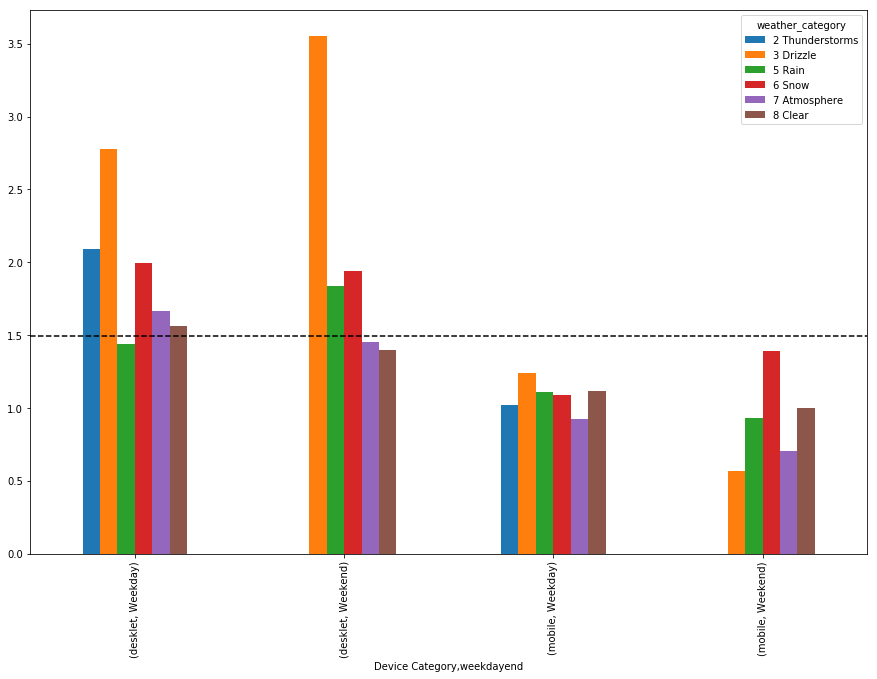

In [32]:
weekdayend_comparison = df2.pivot_table(
    index=['Device Category','weekdayend'], 
    columns='weather_category',values='Revenue Per User', 
    aggfunc=np.average)
# weekdayend_comparison.plot.bar()

weekdayend_comparison_count = df2.pivot_table(
    index=['Device Category','weekdayend'], 
    columns='weather_category',values='Revenue Per User', 
    aggfunc='count')

weekdayend_comparison_count_bool = weekdayend_comparison_count 

# creates a df with boolean values with comparison condition 
for x in list(weekdayend_comparison_count):
    weekdayend_comparison_count_bool[x] = (weekdayend_comparison_count[x] >= 80)

filtered_weekdayend = weekdayend_comparison_count_bool.dropna().multiply(weekdayend_comparison).replace(0, np.nan)

filtered_weekdayend.plot.bar().\
axhline(y=average_df(filtered_weekdayend), color='black', linestyle='--')


no significant difference for new visitors, drizzle higher for weekend for returning visitors

In [33]:
# high season vs low season

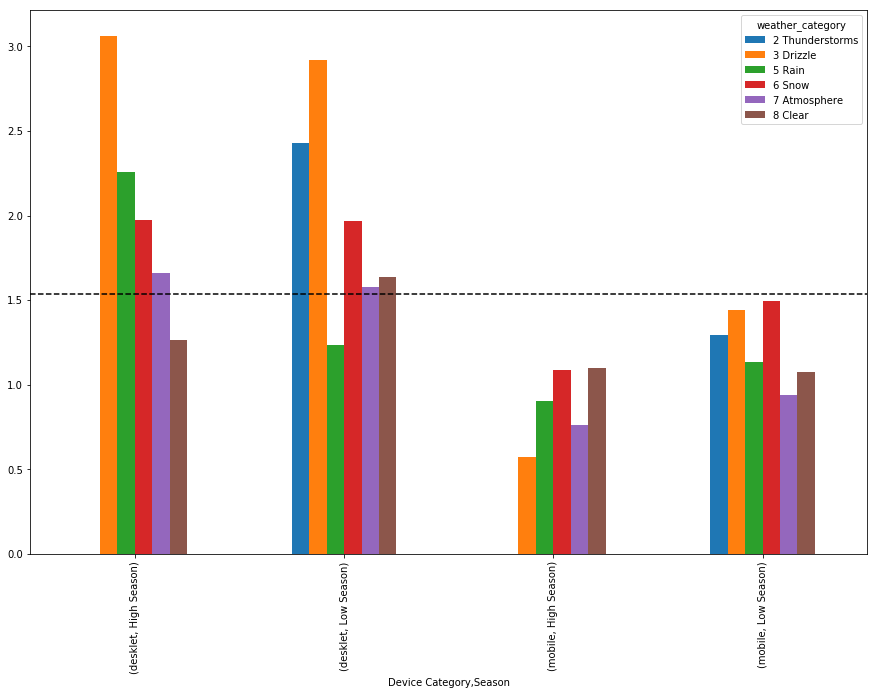

In [34]:
season_comparison = df2.pivot_table(
    index=['Device Category','Season'], 
    columns='weather_category',values='Revenue Per User', 
    aggfunc=np.average)

season_comparison_count = df2.pivot_table(
    index=['Device Category','Season'], 
    columns='weather_category',values='Revenue Per User', 
    aggfunc='count')

season_comparison_count_bool = season_comparison_count 

# creates a df with boolean values with comparison condition 
for x in list(weekdayend_comparison_count):
    season_comparison_count_bool[x] = (season_comparison_count[x] >= 80)

filtered_season = season_comparison_count_bool.dropna().multiply(season_comparison).replace(0, np.nan)

filtered_season.plot.bar().\
axhline(y=average_df(filtered_season), color='black', linestyle='--')


No significant influence of season on new visitors, returning were more likely to buy during drizzle. Why?!


high season sales to returning customers are nil, but for new are not. why?
check the number of thunderstorm days in high season. it should be very low.
but even if that number is low, it warrants looking into why it would be the case
that returning customers did not end up buying anything.

In [35]:
add_total_to_comparitive(filtered_weekdayend,'weekdayend').plot.bar()

weather_category weekdayend  2 Thunderstorms  3 Drizzle    5 Rain    6 Snow  \
0                   Weekday         1.538255   1.950294  1.263888  1.526696   
1                   Weekend         2.613019   2.081335  1.375780  1.664359   

weather_category  7 Atmosphere   8 Clear  
0                     1.261177  1.323247  
1                     1.057128  1.199224  


AttributeError: 'NoneType' object has no attribute 'plot'

In [ ]:
add_total_to_comparitive(filtered_hotcold,'hotcold').plot.bar()
# axhline(y=average_df(add_total_to_comparitive(filtered_hotcold,'hotcold')), color='black', linestyle='--')

In [ ]:
add_total_to_comparitive(season_comparison,'Season').plot.bar()